#### jupyter启动步骤
1. 在pycharm中点击jupyter的|第一个代码块
2. 在右下方“Event Log”中点击“Open in Browser”

In [2]:
from pyecharts import Bar
import matplotlib
from talib import MOM
import os
import pandas as pd
import alphalens as al
from pylab import mpl
import matplotlib.pyplot as plt

# %matplotlib inline

# 正常显示画图时出现的中文和负号
mpl.rcParams['font.sans-serif'] = ['SimHei']
mpl.rcParams['axes.unicode_minus'] = False

print(al.__version__)

0.3.6+7.gdc80cc2.dirty


### 数据格式要求
#### 因子数据
1. 需要处理成 Dataframe 格式，且其索引必须是二维日期和股票代码
#### 价格数据
1. 列为时间，行为股票的 Dataframe
#### 行业数据
1. 可有可无
2. 若有则可以设置成Dict格式或者Series格式

In [3]:
father_dir = os.path.abspath(os.path.dirname(os.getcwd()))  # 上一级目录
grandfather_dir = os.path.abspath(os.path.join(os.getcwd(), "../.."))  # 上上级目录
tushare_path = os.path.join(father_dir, 'data', 'tushare\\')
prices_path = os.path.join(father_dir, 'data', 'prices\\')
factors_path = os.path.join(father_dir, 'data', 'factors\\')

# pandas大于1版本报错：RuntimeError: Cannot set name on a level of a MultiIndex. Use 'MultiIndex.set_names' instead.
# 解决办法：https://github.com/quantopian/alphalens/pull/364/files
prices = pd.read_csv(os.path.join(prices_path, 'prices.csv'), parse_dates=True, index_col=['date'])
factors = pd.read_csv(os.path.join(factors_path, 'factors.csv'), parse_dates=True, index_col=['date', 'asset'])

因子值分组规则：因子值小的排在第一组，因子值大的排在最后一组
https://github.com/quantopian/alphalens/blob/master/alphalens/examples/alphalens_tutorial_on_quantopian.ipynb
quantiles option chooses the buckets to have the same number of items but it doesn't take into
consideration the factor values. For this reason there is another option bins, which chooses the
buckets to be evenly spaced according to the values themselves.

### get_clean_factor_and_forward_returns参数说明
#### groupby，行业分组
1. Either A MultiIndex Series indexed by date and asset,containing the period wise group codes for each asset
2. or a dict of asset to group mappings. If a dict is passed, it is assumed that group mappings are unchanged for the entire time period of the passed factor data.
#### binning_by_group, 是否按照行业分组， bool
#### quantiles, 分组个数
1. Number of equal-sized quantile buckets to use in factor bucketing.
2. Alternately sequence of quantiles, allowing non-equal-sized buckets, e.g. [0, .10, .5, .90, 1.] or [.05, .5, .95]
3. Only one of 'quantiles' or 'bins' can be not-None
#### bins，直方图个数
1. Number of equal-width (valuewise) bins to use in factor bucketing.
2. Alternately sequence of bin edges allowing for non-uniform bin width, e.g. [-4, -2, -0.5, 0, 10]
3. Chooses the buckets to be evenly spaced according to the values themselves. Useful when the factor contains discrete values.
#### periods
1. periods to compute forward returns on.
#### filter_zscore 异常值阀值设定
1. Sets forward returns greater than X standard deviations from the the mean to nan. Set it to 'None' to avoid filtering.
2. Caution: this outlier filtering incorporates lookahead bias.
#### groupby_labels : dict
1. A dictionary keyed by group code with values corresponding to the display name for each group.
#### max_loss : float, optional
1. Maximum percentage (0.00 to 1.00) of factor data dropping allowed, computed comparing the number of items in the input factor index and the number of items in the output DataFrame index.
2. Factor data can be partially dropped due to being flawed itself (e.g. NaNs), not having provided enough price data to compute forward returns for all factor values, or because it is not possible to perform binning.
3. Set max_loss=0 to avoid Exceptions suppression.
#### zero_aware : bool, optional
1. If True, compute quantile buckets separately for positive and negative signal values. This is useful if your signal is centered and zero is the separation between long and short signals, respectively.
#### cumulative_returns : bool, optional
1. If True, forward returns columns will contain cumulative returns.
2. Setting this to False is useful if you want to analyze how predictive a factor is for a single forward day.

In [4]:
factor_data = al.utils.get_clean_factor_and_forward_returns(factor=factors,
                                                            prices=prices,
                                                            groupby=None,
                                                            binning_by_group=False,
                                                            quantiles=5,  # None
                                                            bins=None,  # [0, 0.2, 0.4, 0.8, 1.0]
                                                            periods=(1, 3, 5),
                                                            filter_zscore=20,
                                                            groupby_labels=None,
                                                            max_loss=0.35,
                                                            zero_aware=False,
                                                            cumulative_returns=True)

Dropped 1.2% entries from factor data: 0.6% in forward returns computation and 0.6% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!


In [ ]:
al.tears.create_full_tear_sheet(factor_data, long_short=True, group_neutral=False, by_group=False)

In [ ]:
al.tears.create_full_tear_sheet(factor_data, long_short=True, group_neutral=False, by_group=False)

Quantiles Statistics


,min,max,mean,std,count,count %
factor_quantile,,,,,,
1.0,-0.332440,0.028391,-0.034426,0.028373,6544,20.000000
2.0,-0.092255,0.046315,-0.010783,0.014492,6545,20.003056
3.0,-0.080499,0.062157,0.000723,0.013247,6544,20.000000
4.0,-0.057778,0.103433,0.012900,0.013981,6543,19.996944
5.0,-0.028617,10.062626,0.039270,0.127039,6544,20.000000


Returns Analysis


,1D,3D,5D
Ann. alpha,0.140,0.076,0.058
beta,-0.071,-0.052,-0.072
Mean Period Wise Return Top Quantile (bps),2.328,1.096,1.397
Mean Period Wise Return Bottom Quantile (bps),-2.533,-1.092,-0.718
Mean Period Wise Spread (bps),4.862,2.201,2.133


E:\E_GitHubRepos\alphalens\venv\lib\site-packages\pandas\core\arrays\datetimes.py:702: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex
  warnings.warn(
E:\E_GitHubRepos\alphalens\venv\lib\site-packages\pandas\core\arrays\datetimes.py:702: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex
  warnings.warn(
E:\E_GitHubRepos\alphalens\venv\lib\site-packages\pandas\core\arrays\datetimes.py:702: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex
  warnings.warn(
E:\E_GitHubRepos\alphalens\venv\lib\site-packages\pandas\core\arrays\datetimes.py:702: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex
  warnings.warn(


<Figure size 432x288 with 0 Axes>

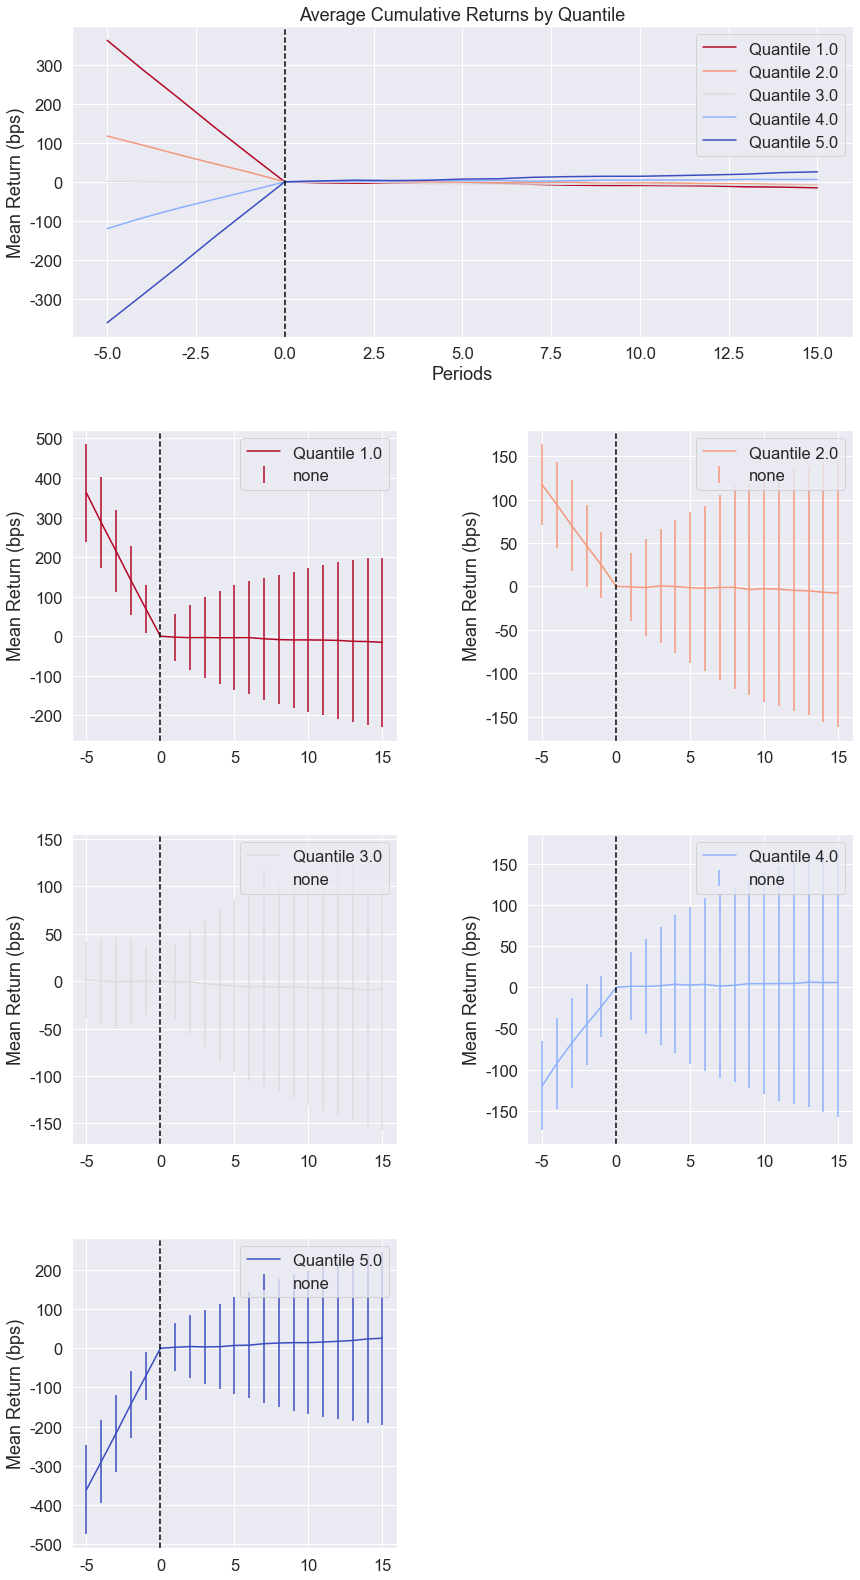

In [6]:
al.tears.create_event_returns_tear_sheet(factor_data, prices,
                                         avgretplot=(5, 15),
                                         long_short=True,
                                         group_neutral=False,
                                         std_bar=True,
                                         by_group=False)

Quantiles Statistics


,min,max,mean,std,count,count %
factor_quantile,,,,,,
1.0,-0.332440,0.028391,-0.034426,0.028373,6544,20.000000
2.0,-0.092255,0.046315,-0.010783,0.014492,6545,20.003056
3.0,-0.080499,0.062157,0.000723,0.013247,6544,20.000000
4.0,-0.057778,0.103433,0.012900,0.013981,6543,19.996944
5.0,-0.028617,10.062626,0.039270,0.127039,6544,20.000000


Returns Analysis


,1D,3D,5D
Ann. alpha,0.140,0.076,0.058
beta,-0.071,-0.052,-0.072
Mean Period Wise Return Top Quantile (bps),2.328,1.096,1.397
Mean Period Wise Return Bottom Quantile (bps),-2.533,-1.092,-0.718
Mean Period Wise Spread (bps),4.862,2.201,2.133


Information Analysis


,1D,3D,5D
IC Mean,-0.016,-0.011,-0.003
IC Std.,0.245,0.234,0.232
Risk-Adjusted IC,-0.065,-0.048,-0.013
t-stat(IC),-1.847,-1.371,-0.371
p-value(IC),0.065,0.171,0.710
IC Skew,0.017,-0.038,-0.104
IC Kurtosis,-0.106,-0.344,-0.285


E:\E_GitHubRepos\alphalens\venv\lib\site-packages\pandas\core\arrays\datetimes.py:702: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex
  warnings.warn(
E:\E_GitHubRepos\alphalens\venv\lib\site-packages\pandas\core\arrays\datetimes.py:702: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex
  warnings.warn(
E:\E_GitHubRepos\alphalens\venv\lib\site-packages\pandas\core\arrays\datetimes.py:702: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex
  warnings.warn(
E:\E_GitHubRepos\alphalens\venv\lib\site-packages\pandas\core\arrays\datetimes.py:702: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex
  warnings.warn(
E:\E_GitHubRepos\alphalens\venv\lib\site-packages\pandas\core\arrays\datetimes.py:702: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex
  warnings.warn(
E:\E_GitHubRepos\alphalens\venv\lib\site-pack

Turnover Analysis


,1D,3D,5D
Quantile 1 Mean Turnover,0.355,0.607,0.771
Quantile 2 Mean Turnover,0.605,0.741,0.792
Quantile 3 Mean Turnover,0.645,0.757,0.777
Quantile 4 Mean Turnover,0.596,0.748,0.801
Quantile 5 Mean Turnover,0.338,0.604,0.778


,1D,3D,5D
Mean Factor Rank Autocorrelation,0.754,0.353,-0.002


<Figure size 432x288 with 0 Axes>

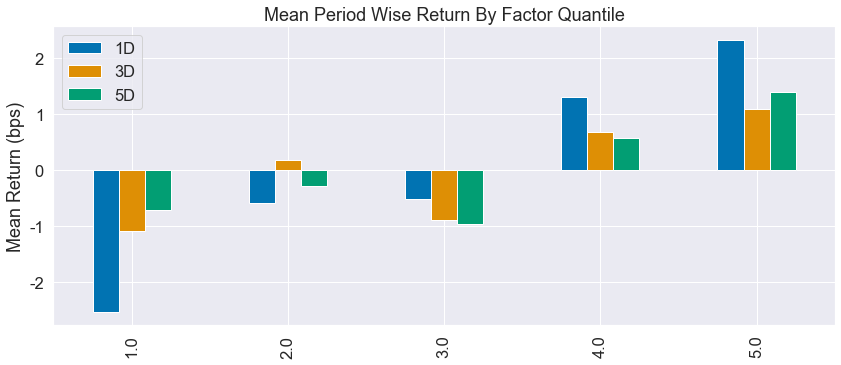

In [7]:
al.tears.create_summary_tear_sheet(factor_data, long_short=True, group_neutral=False)

Returns Analysis


,1D,3D,5D
Ann. alpha,0.140,0.076,0.058
beta,-0.071,-0.052,-0.072
Mean Period Wise Return Top Quantile (bps),2.328,1.096,1.397
Mean Period Wise Return Bottom Quantile (bps),-2.533,-1.092,-0.718
Mean Period Wise Spread (bps),4.862,2.201,2.133


E:\E_GitHubRepos\alphalens\venv\lib\site-packages\pandas\core\arrays\datetimes.py:702: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex
  warnings.warn(
E:\E_GitHubRepos\alphalens\venv\lib\site-packages\pandas\core\arrays\datetimes.py:702: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex
  warnings.warn(
E:\E_GitHubRepos\alphalens\venv\lib\site-packages\pandas\core\arrays\datetimes.py:702: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex
  warnings.warn(
E:\E_GitHubRepos\alphalens\venv\lib\site-packages\pandas\core\arrays\datetimes.py:702: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex
  warnings.warn(
E:\E_GitHubRepos\alphalens\venv\lib\site-packages\pandas\core\arrays\datetimes.py:702: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex
  warnings.warn(
E:\E_GitHubRepos\alphalens\venv\lib\site-pack

<Figure size 432x288 with 0 Axes>

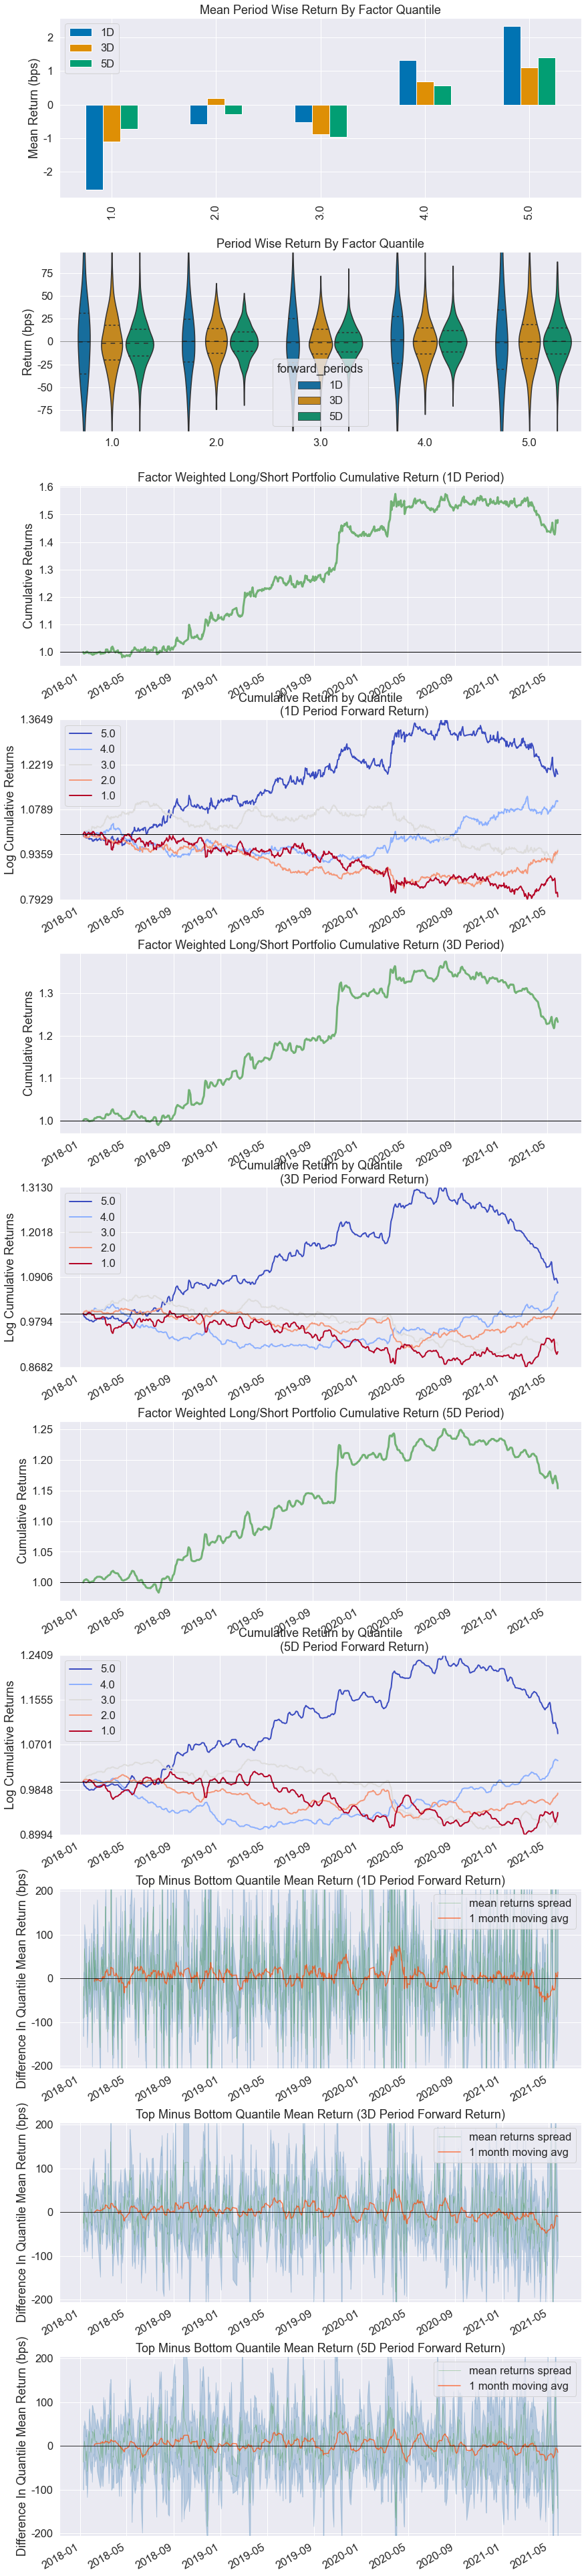

In [8]:
al.tears.create_returns_tear_sheet(factor_data, long_short=True, group_neutral=False, by_group=False)

Information Analysis


,1D,3D,5D
IC Mean,-0.016,-0.011,-0.003
IC Std.,0.245,0.234,0.232
Risk-Adjusted IC,-0.065,-0.048,-0.013
t-stat(IC),-1.847,-1.371,-0.371
p-value(IC),0.065,0.171,0.710
IC Skew,0.017,-0.038,-0.104
IC Kurtosis,-0.106,-0.344,-0.285


E:\E_GitHubRepos\alphalens\venv\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
E:\E_GitHubRepos\alphalens\venv\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
E:\E_GitHubRepos\alphalens\venv\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `h

<Figure size 432x288 with 0 Axes>

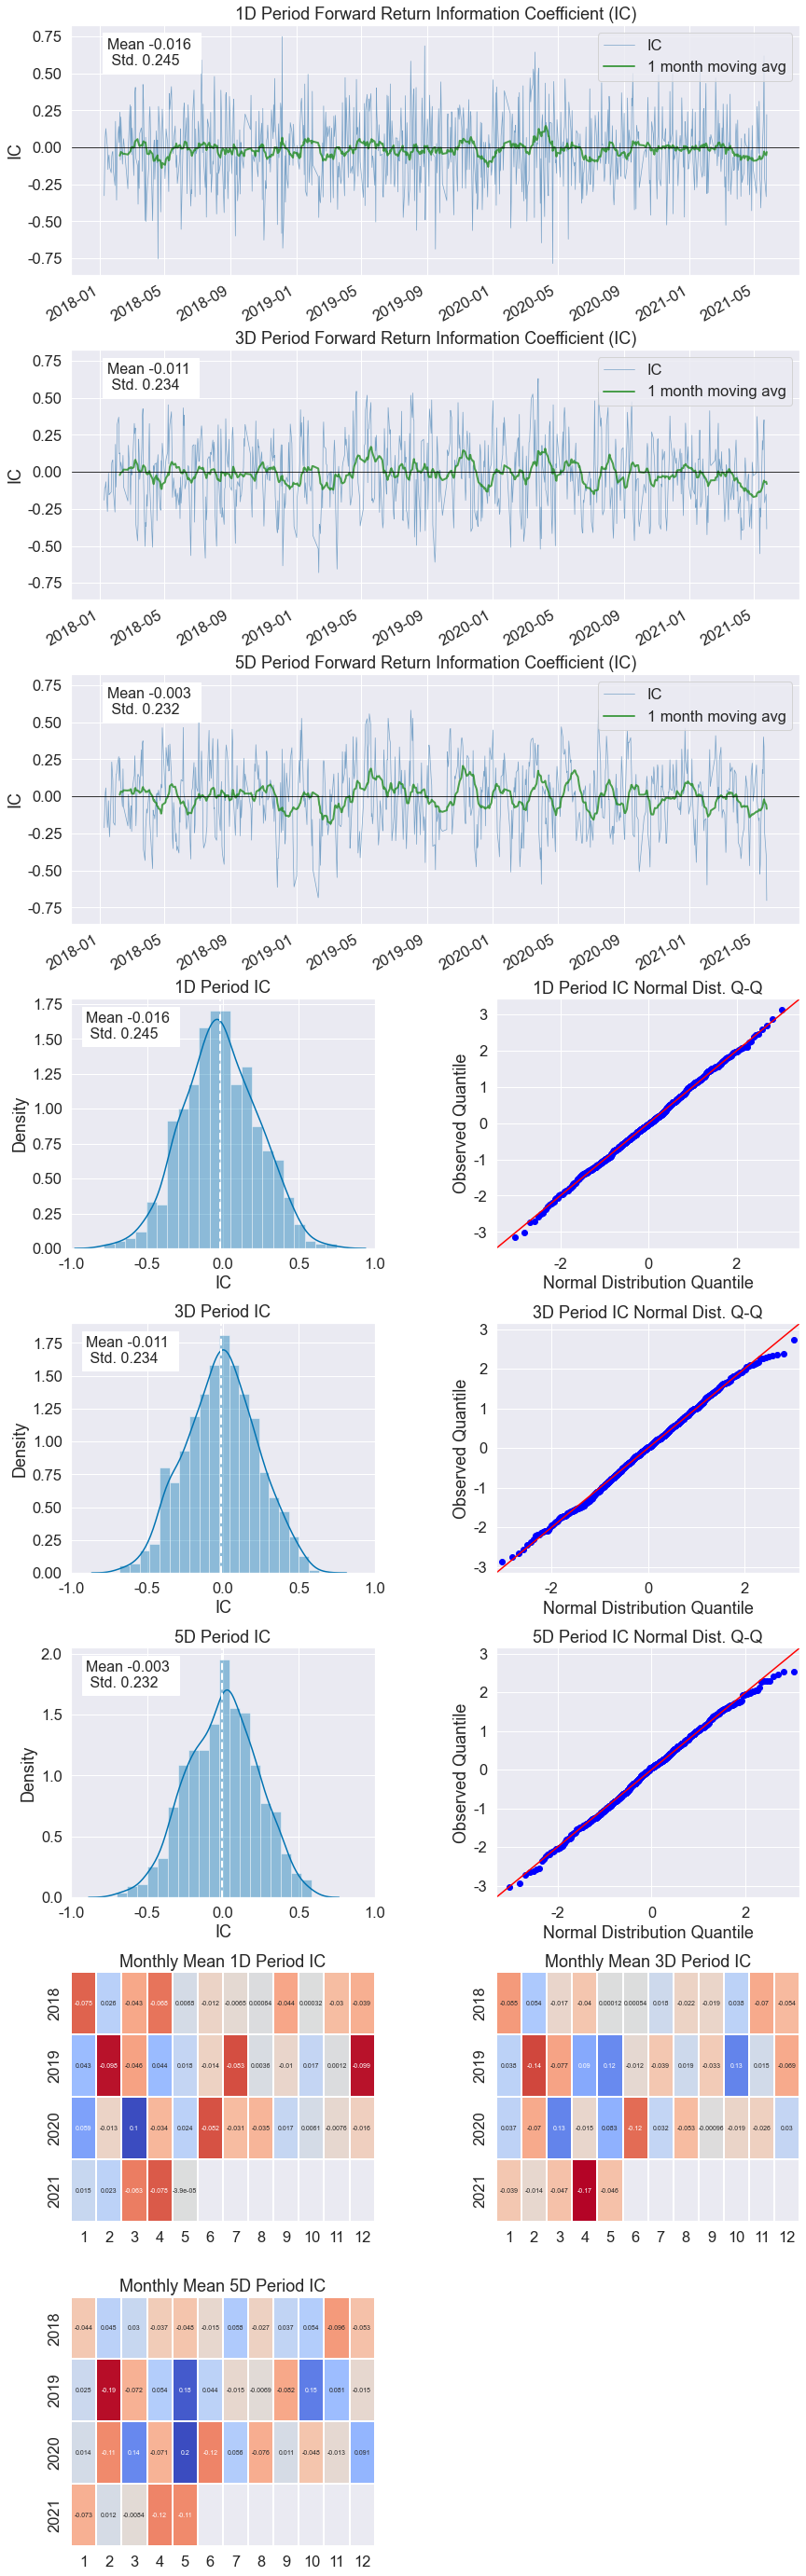

In [9]:
al.tears.create_information_tear_sheet(factor_data, group_neutral=False, by_group=False)

E:\E_GitHubRepos\alphalens\venv\lib\site-packages\pandas\core\arrays\datetimes.py:702: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex
  warnings.warn(
E:\E_GitHubRepos\alphalens\venv\lib\site-packages\pandas\core\arrays\datetimes.py:702: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex
  warnings.warn(
E:\E_GitHubRepos\alphalens\venv\lib\site-packages\pandas\core\arrays\datetimes.py:702: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex
  warnings.warn(
E:\E_GitHubRepos\alphalens\venv\lib\site-packages\pandas\core\arrays\datetimes.py:702: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex
  warnings.warn(
E:\E_GitHubRepos\alphalens\venv\lib\site-packages\pandas\core\arrays\datetimes.py:702: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex
  warnings.warn(
E:\E_GitHubRepos\alphalens\venv\lib\site-pack

Turnover Analysis


,1D,3D,5D
Quantile 1 Mean Turnover,0.355,0.607,0.771
Quantile 2 Mean Turnover,0.605,0.741,0.792
Quantile 3 Mean Turnover,0.645,0.757,0.777
Quantile 4 Mean Turnover,0.596,0.748,0.801
Quantile 5 Mean Turnover,0.338,0.604,0.778


,1D,3D,5D
Mean Factor Rank Autocorrelation,0.754,0.353,-0.002


<Figure size 432x288 with 0 Axes>

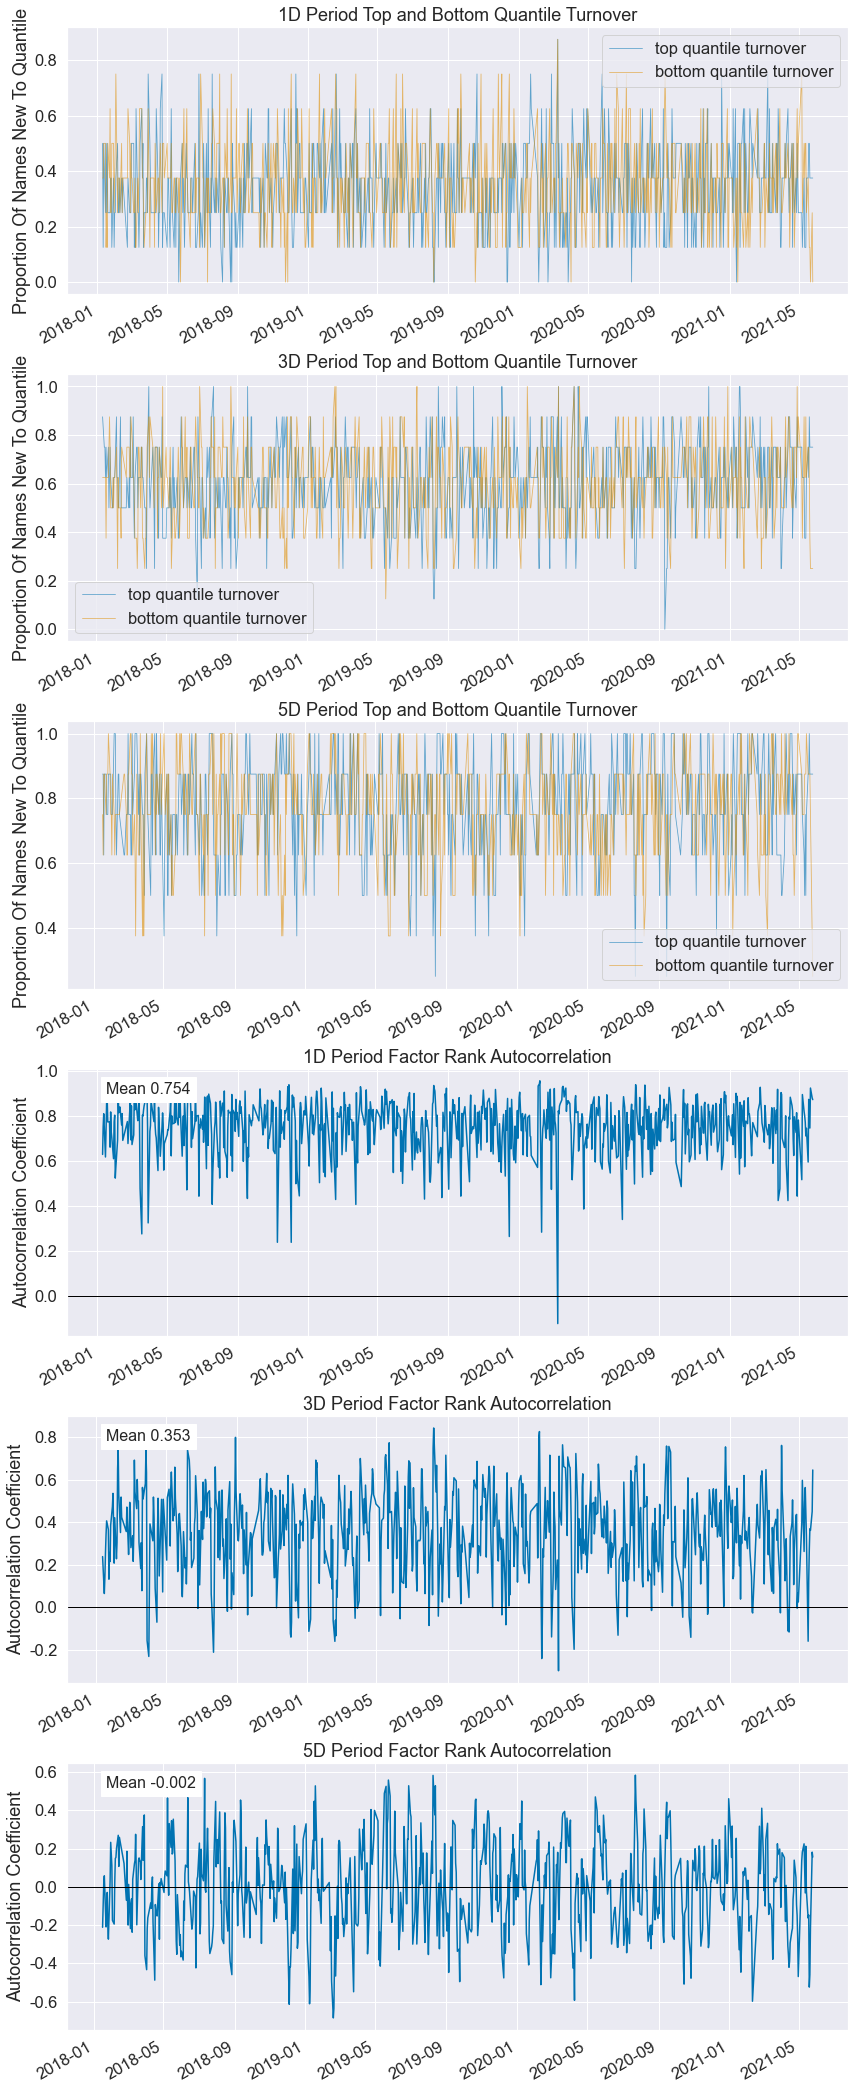

In [10]:
al.tears.create_turnover_tear_sheet(factor_data)

In [11]:
ic = al.performance.mean_information_coefficient(factor_data, by_time='1y')

attr = ic.index.strftime('%Y')
v1 = list(ic['1D'].round(2))
v2 = list(ic['3D'].round(2))
v3 = list(ic['5D'].round(2))
bar = Bar('IC均值：2006-2019')
bar.add('1D', attr, v1)
bar.add('3D', attr, v2)
bar.add('5D', attr, v3)
bar.render()


In [12]:
factor_data

1D        3D        5D    factor  factor_quantile
date       asset                                                         
2018-01-09 A      0.005441 -0.008705 -0.019859  0.010116              4.0
           B     -0.021806 -0.020270 -0.031941 -0.005208              2.0
           C      0.001643  0.000548 -0.002191 -0.001642              2.0
           CS     0.001414  0.002357  0.007072 -0.008451              1.0
           FB     0.000000 -0.043980 -0.072567 -0.112209              1.0
...                    ...       ...       ...       ...              ...
2021-05-25 SM    -0.003561  0.022186  0.064366 -0.018991              4.0
           SR    -0.008892 -0.016717 -0.002490 -0.008676              4.0
           TA    -0.002115 -0.006768  0.024112 -0.010101              4.0
           WH     0.000000 -0.000361  0.002168 -0.013991              4.0
           ZC    -0.007926  0.026237  0.099207 -0.140035              1.0

[32720 rows x 5 columns]